In [9]:
# Libraries needed 
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist


In [10]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

## Transferring data into a dataframe 

In [11]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [12]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [13]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [14]:
def concatenate_dfs(dfs, sort_cols):
    
    df_to_concat = dfs
    df_complete = pd.concat(df_to_concat)
    df_complete.sort_values(by = sort_cols, inplace = True)
    df_complete.reset_index(inplace=True, drop=True)
    
    return df_complete

df_complete = concatenate_dfs([df_109,df_130,df_142,df_143] , ['frame', 'camera'])
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109
11741,-1.906789,-5.313489,-2.293509,3.833054,0.585950,0.395508,-0.462055,1.574333e+09,749,142
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142
11743,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143


## Frame visualization

In [15]:
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )


def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    
    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        # first face 
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        # second face 
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        
        
        combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
            (7,4)] + [(i,i+4) for i in range(4)]
        
        for (i,j) in combinations: 
            vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
            vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
        
        
    visualize_frame_detections ( camera, frame_idx, s = s )
    
    return


def visualize_alldetections(df, frame_idx):
    ''' Visualize all detections from above'''
    
    x = df['X_box'][df['frame'] == frame_idx]
    y = df['Y_box'][df['frame'] == frame_idx]

    plt.scatter(x,y)
    display(df[df['frame'] == frame_idx])
    

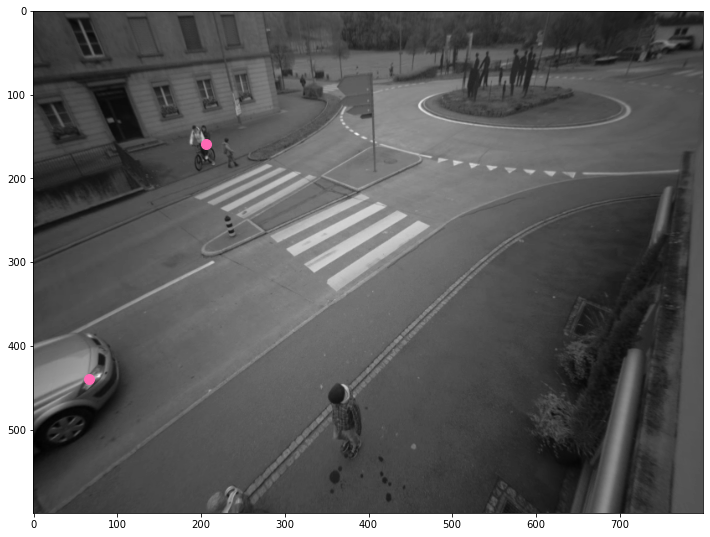

In [171]:
visualize_frame_detections(hdf5data_109,150, figsize = (12,12))

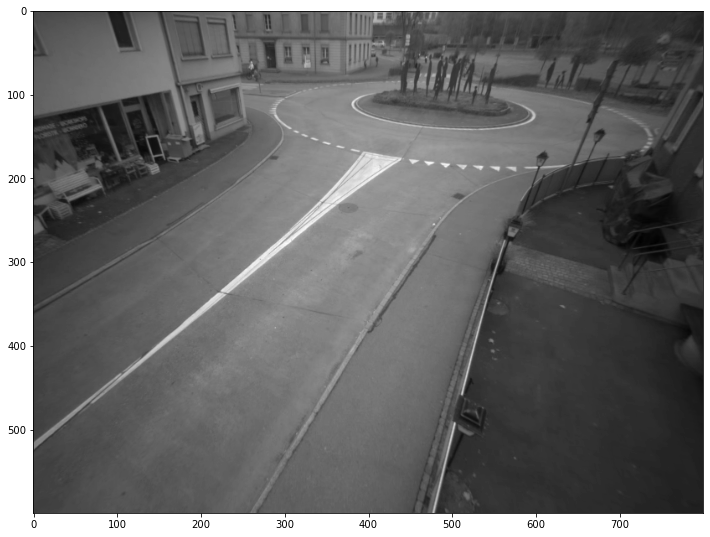

In [172]:
visualize_frame_boxes(hdf5data_130, 150, figsize = (12,12), s = 20)

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
5,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
6,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
7,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
8,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143


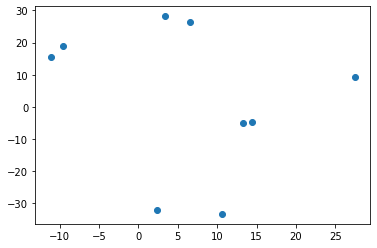

In [30]:
visualize_alldetections(df_complete, 0)

In [19]:
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109
11741,-1.906789,-5.313489,-2.293509,3.833054,0.585950,0.395508,-0.462055,1.574333e+09,749,142
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142
11743,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143


# Tracker Skeleton

In [20]:
### Class representing a single detection

class Object:
    def __init__(self, x, y, z, l, w, h, angle, camera):
        self.x = x
        self.y = y
        self.z = z
        self.length = l
        self.width = w
        self.height = h
        self.angle = angle
        self.camera = camera
        
    def to_df(self):
        ''' Print object as dataframe'''
        df = pd.DataFrame([[self.x, self.y, self.z, self.length, self.width, self.height, self.angle, self.camera]], 
                         columns = ['x', 'y', 'z', 'length', 'width', 'height', 'angle', 'camera'])

        return df

In [21]:
### Class representing the Tracks

deltaT = 0.08 # Difference in timestamps - NOT USED
threshold = 5 # Used to move a track to Inactive

class Track:
    
    def __init__(self, ID, OBJ, FRAME, threshold = threshold):
        self.ID = ID
        self.status = 'New'  #New, Pending, Active, Inactive
        self.objects = [OBJ]
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
        self.frames = [FRAME]
        self.velocity = []
        self.type = None
        self.threshold = threshold
        self.filter = None
        
        self.new_time = 0
        self.pending_time = 0
    
    def update(self, OBJ, FRAME):
        
        if OBJ is not None:
            self.objects.append(OBJ)
            self.frames.append(FRAME)
            self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z #We should use KF.filter
            self.status = 'Active'
        
        if OBJ is None and self.status == 'New':
            if self.new_time == 1: self.status = 'Removed'
            else: self.new_time += 1
        
        if OBJ is None and self.status == 'Active':
            self.status = 'Pending'
            self.pending_time += 1
        
        if OBJ is None and self.status == 'Pending':
            if self.pending_time == threshold: self.status = 'Inactive'
            else: self.pending_time += 1
        
        return
    
    def set_status(self, status):
        self.status = status
        
        return
    
    def compute_vel ( self, OBJ ): #TO DO WITH KALMAN FILTERS NOT THIS SH*T
        ### TO IMPLEMENT ###
        vx = (OBJ['x'] - self.objects[-1]['x'])/deltaT
        vy = (OBJ['y'] - self.objects[-1]['y'])/deltaT
        vz = (OBJ['z'] - self.objects[-1]['z'])/deltaT
        
        self.velocity.append((vx,vy, vz))
        
        return
    
    def set_type( self, TYPE ):
        ### NOT USED ###
        self.type = TYPE
        set_threshold()
        return
    
    def set_threshold (self):
        ### NOT USED ###
        if type == 'car':
            self.threshold = 3
        
        else:
            self.threshold = 10
            
        return
    
    def to_df(self):
        '''Print Trajectory as Dataframe'''
        df = pd.DataFrame(columns = ['x', 'y', 'z', 'length', 'width', 'height', 'angle', 'camera'])
        for i, j in enumerate(self.objects):
            append_df = j.to_df()
            append_df['frame'] = self.frames[i]       
            df = df.append(append_df)
            df.reset_index(inplace=True, drop=True)
            
        return df
    

In [22]:
#Functions used to associate tracks and detections
#Using NN up to now, SHITTY


def track_detection_association(track_coord, obj_coord):
    ''' Function for association between detections and tracks'''
    
    dists = cdist(track_coord, obj_coord, 'euclidean') 
    associations = np.argmin(dists, axis=1)
    
    associations[np.min(dists, axis = 1) > 0.5] = -1
    #print(associations)
    return associations

def associate(track_coord, tracks, status, obj_list, frame_index):
    ''' Input list of coordinates, tracks and objects, return tracks associated with detections'''
    
    if track_coord.size and len(obj_list) > 0:
        
        obj_coord = [(obj.x, obj.y, obj.z) for obj in obj_list]
        associations = track_detection_association(track_coord, obj_coord)
        #print(associations)
        
        for index, ass in enumerate(associations):
            if ass == -1:
                tracks[status][index].update(None, frame_index)
            else:
                tracks[status][index].update(obj_list[ass], frame_index)

        obj_list = np.delete(obj_list, associations)
    
    return tracks, obj_list

In [23]:
# Class tracker

class Tracker:
    
    def __init__(self, dfs):
        self.tracks = {'Active': [], 'Pending': [], 'Inactive': [], 'New': [], 'Removed': []}
        self.dataframe = concatenate_dfs(dfs, ['frame', 'camera'])
        self.track_id = 0
        self.frame_index = 0
    
    def update_tracks(self):
        ''' Update the status of the tracks, moving them to the different lists'''
        for tr in self.tracks['New'][::-1]:
            if tr.status != 'New':
                self.tracks['New'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Pending'][::-1]:
            if tr.status != 'Pending':
                self.tracks['Pending'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Active'][::-1]:
            if tr.status != 'Active':
                self.tracks['Active'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        return
    
    def next_step(self):
        ''' Increase time step of the camera'''
        self.frame_index += 1
    
    def analyze_frame(self):
        ''' Analize frame creating trajectories'''
        
        frame = self.dataframe[self.dataframe['frame'] == self.frame_index]
        frame.reset_index(inplace=True, drop=True)
        obj_list = []
        
        # Extract all the detections in the frame
        for index, row in frame.iterrows():
            obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], 
                         row['width_box'], row['height_box'], row['angle_box'], row['camera'])
            obj_list.append(obj)

        obj_list = np.array(obj_list)
        
        # At first we use Active Tracks
        track_act_coord = np.array([[t.x, t.y, t.z] for t in self.tracks['Active']]) #We should use KF.predict here and not consider only the new set
        self.tracks, obj_list = associate(track_act_coord, self.tracks, 'Active', obj_list, self.frame_index)

        #Then we use tracks set as New
        track_new_coord = np.array([[t.x, t.y, t.z] for t in self.tracks['New']]) #We should use KF.predict here and not consider only the new set
        self.tracks, obj_list = associate(track_new_coord, self.tracks, 'New', obj_list, self.frame_index)

        #Then we use tracks set as Pending
        track_pending_coord = np.array([[t.x, t.y, t.z] for t in self.tracks['Pending']]) #We should use KF.predict here and not consider only the new set
        self.tracks, obj_list = associate(track_pending_coord, self.tracks, 'Pending', obj_list, self.frame_index)

        
        # Check status of all tracks
        self.update_tracks()
        
        #Create new tracks for not linked objects
        for obj in obj_list:
            tr = Track(self.track_id, obj, self.frame_index)
            self.track_id += 1
            self.tracks['New'].append(tr)
        
        #Go to the next frame
        self.next_step()

In [24]:
# Create Tracker, analyze some frames
TrackTrack = Tracker([df_109,df_130,df_142,df_143])
for _ in range(30): TrackTrack.analyze_frame()

In [25]:
#Print one trajectory as dataframe
TrackTrack.tracks['Inactive'][5].to_df()

,x,y,z,length,width,height,angle,camera,frame
0,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,130.0,0.0
1,27.366480,9.388028,-0.620996,2.423051,0.704623,1.189200,-0.820607,130.0,1.0
2,27.402643,9.444654,-0.564636,2.396153,0.799055,1.143541,-0.822731,130.0,2.0
3,27.363467,9.574638,-0.524335,2.298871,0.618833,0.873361,-0.769775,130.0,3.0
4,27.342745,9.669458,-0.558172,1.376027,0.547921,1.003843,-0.703525,130.0,4.0
5,27.201655,9.868030,-0.440152,1.302547,0.771170,0.410919,-1.092147,130.0,5.0
6,27.209659,9.810051,-0.392463,1.174977,0.543666,0.209451,-0.667013,130.0,6.0


,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,5.468896,16.077170,-1.011798,6.500671,2.841673,1.843332,-1.043262,1.574333e+09,30,109
1,-10.701534,15.651974,-1.256557,1.176765,0.704346,2.001044,0.950776,1.574333e+09,30,109
2,-10.783676,17.393278,-1.250210,1.140057,0.469105,1.039042,0.846807,1.574333e+09,30,109
3,-7.022000,21.473612,-1.197526,0.967333,0.607665,1.408762,1.194360,1.574333e+09,30,109
4,6.562718,26.660899,-0.837091,2.286082,0.514131,1.232534,0.948504,1.574333e+09,30,109
5,3.430720,28.001986,-1.374276,4.341066,2.270165,3.090975,1.298790,1.574333e+09,30,109
6,1.352511,-14.735196,-1.140171,3.937391,3.136503,1.898772,-0.641329,1.574333e+09,30,130
7,7.864159,12.462437,-1.162964,7.639341,3.609999,1.999347,-1.062302,1.574333e+09,30,130
8,-1.142767,-16.539500,-1.307322,8.871377,3.169545,2.776341,-0.881502,1.574333e+09,30,142
9,-20.093247,-7.405957,-0.973540,1.587125,0.911633,2.138095,-1.081944,1.574333e+09,30,142


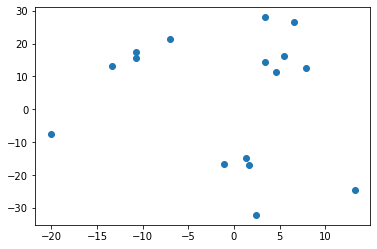

In [259]:
idx = 30
frame = df_complete.loc[df_complete.loc[:,'frame'] == idx,:]
frame.reset_index(inplace=True, drop=True)
visualize_alldetections(frame, idx)

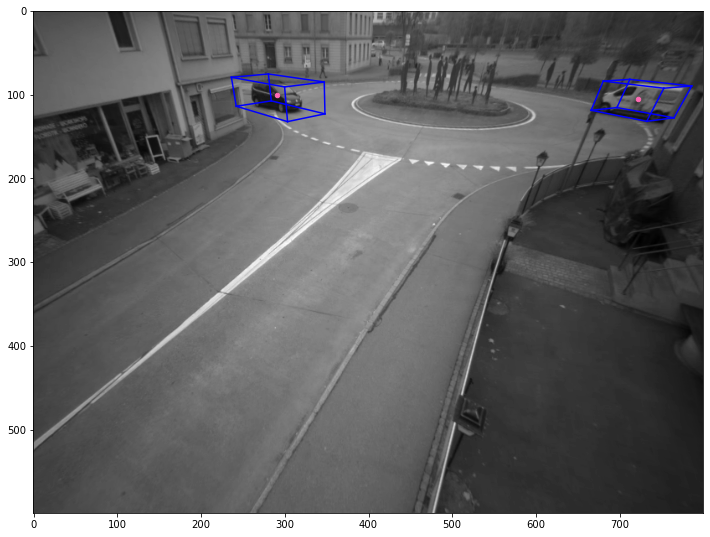

In [260]:
visualize_frame_boxes(hdf5data_130, 30, figsize = (12,12), s = 20)

In [261]:
o1 = frame.iloc[:,:3].values
dists = cdist(o1, o1, 'euclidean')
dists

len(frame.index)
frame.loc[:,'ind'] = None

for index in range(len(frame.index)):
    
    if frame.loc[index, 'ind'] is None:
        frame.loc[index, 'ind'] = index
        ind = index

    else:
        ind = frame.loc[index, 'ind']
    
    dist_o = dists[index]
    candidates = np.where(dist_o < 4.5)[0]
    candidates = candidates[np.where(candidates > index)]
    print(candidates)
    
    for i in candidates:
        if frame.loc[index, 'camera'] != frame.loc[i, 'camera']:
            frame.loc[i,'ind'] = ind
        

def unify(frame, method = 'euclidean'):
    
    #coordinates of centers
    coords = frame.iloc[:,:3].values 
    
    #method
    dists = cdist(coords, coords, 'euclidean')
    
    #initializing indexes
    frame.loc[:,'ind'] = None
    
    for index in range(len(frame.index)):
    
        if frame.loc[index, 'ind'] is None:
            frame.loc[index, 'ind'] = index
            ind = index

        else:
            ind = frame.loc[index, 'ind']
    
        dist_o = dists[index]
        candidates = np.where(dist_o < 4.5)[0]
        candidates = candidates[np.where(candidates > index)]
    
        for i in candidates:
            if frame.loc[index, 'camera'] != frame.loc[i, 'camera']:
                frame.loc[i,'ind'] = ind
    return frame

frame

[ 7 12]
[ 2 11]
[]
[]
[5]
[]
[ 8 15]
[10]
[15]
[]
[12]
[]
[]
[]
[]
[]


C:\Users\david\anaconda3\envs\Viscando\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\david\anaconda3\envs\Viscando\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,ind
0,5.468896,16.077170,-1.011798,6.500671,2.841673,1.843332,-1.043262,1.574333e+09,30,109,0
1,-10.701534,15.651974,-1.256557,1.176765,0.704346,2.001044,0.950776,1.574333e+09,30,109,1
2,-10.783676,17.393278,-1.250210,1.140057,0.469105,1.039042,0.846807,1.574333e+09,30,109,2
3,-7.022000,21.473612,-1.197526,0.967333,0.607665,1.408762,1.194360,1.574333e+09,30,109,3
4,6.562718,26.660899,-0.837091,2.286082,0.514131,1.232534,0.948504,1.574333e+09,30,109,4
5,3.430720,28.001986,-1.374276,4.341066,2.270165,3.090975,1.298790,1.574333e+09,30,109,5
6,1.352511,-14.735196,-1.140171,3.937391,3.136503,1.898772,-0.641329,1.574333e+09,30,130,6
7,7.864159,12.462437,-1.162964,7.639341,3.609999,1.999347,-1.062302,1.574333e+09,30,130,0
8,-1.142767,-16.539500,-1.307322,8.871377,3.169545,2.776341,-0.881502,1.574333e+09,30,142,6
9,-20.093247,-7.405957,-0.973540,1.587125,0.911633,2.138095,-1.081944,1.574333e+09,30,142,9


In [276]:
frame2 = df_complete.loc[df_complete.loc[:,'frame'] == idx,:]
frame2.reset_index(inplace=True, drop=True)
frame2['ind'] = None

def attempt(df, threshold=0.2, return_iou=True):
    
    """
    Optionally it will also return ious
    """
    
    iou_vec = np.zeros(shape=len(df.index))
    matches = -np.ones(shape=len(df.index), dtype=np.int8)
    for i in range(len(df.index)):
        for j in range(len(df.index)):
            
            df1 = df.iloc[i,:]
            df2 = df.iloc[j,:]
            iou = compute_approx_IoU2(df1,df2)
            if iou > iou_vec[i] and iou > threshold: # can be refined to also account for very different volumes
                iou_vec[i] = iou
                matches[i] = j
        #print(matches)        
        #can use this to check if there is any split, uncertainty, etc
        if not return_iou:
            return matches
    return matches, iou_vec

def compute_approx_IoU2(box1, box2, attempts=10): #TODO increment number iterations
    
    #print(box1)
    #print(box2)
    

    pos1 = box1[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    pos2 = box2[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    #print(pos1, pos2)
    length1 = box1['length_box']
    width1 = box1['width_box']
    height1 = box1['height_box']
    length2 = box2['length_box']
    width2 = box2['width_box']
    height2 = box2['height_box']
    diag1 = np.sqrt(length1**2+width1**2+height1**2)
    diag2 = np.sqrt(length2**2+width2**2+height2**2)
    rotation_matrix1 = np.array([[np.cos(box1['angle_box']), -np.sin(box1['angle_box']), 0], 
                            [np.sin(box1['angle_box']), np.cos(box1['angle_box']), 0], 
                            [0,0,1]])
    rotation_matrix2 = np.array([[np.cos(box2['angle_box']), -np.sin(box2['angle_box']), 0], 
                            [np.sin(box2['angle_box']), np.cos(box2['angle_box']), 0], 
                            [0,0,1]])
    
    
    if np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2+(pos1[2]-pos2[2])**2)>max(diag1, diag2):
        return 0
    intersection = 0
    #print("arr",np.array([length1,width1,height1]))
    for i in range(attempts):
        u = np.random.uniform(-1,1,size=3) * np.array([length1,width1,height1])/2 
        #print(np.array([i for i in pos1]))
        #print("u: ", u)
        u = rotation_matrix1.dot(u)
        if belongs_to2(u + np.array([i for i in pos1]), box2, True):
            intersection +=1
        u = np.random.uniform(-1,1,size=3) * np.array([length2,width2,height2])/2 
        u = rotation_matrix2.dot(u)
        if belongs_to2(u + np.array([i for i in pos2]), box1, True):
            intersection +=1
    return intersection/2/attempts

def belongs_to2(point, box, isdf=False):
    #print(point)
    if isdf:
        center = box[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
        point = np.array([i for i in point]) - center
        anti_rotation_matrix = np.array([[np.cos(-box['angle_box']), -np.sin(-box['angle_box']), 0], 
                            [np.sin(-box['angle_box']), np.cos(-box['angle_box']), 0], 
                            [0,0,1]])
        rot_point = anti_rotation_matrix.dot(point)
        #print("point: ", point)
        #print(rot_point)
        if np.abs(rot_point[0])<box['length_box']/2 and np.abs(rot_point[1])<box['width_box']/2 and np.abs(rot_point[2])<box['height_box']/2:
            return True
        return False
    
    center = np.array([i for i in box[0]])
    point = np.array([i for i in point]) - center
    anti_rotation_matrix = np.array([[np.cos(-box[4]), -np.sin(-box[4]), 0], 
                            [np.sin(-box[4]), np.cos(-box[4]), 0], 
                            [0,0,1]])
    rot_point = anti_rotation_matrix.dot(point)
    
    if np.abs(rot_point[0])<box[1]/2 and np.abs(rot_point[1])<box[2]/2 and np.abs(rot_point[2])<box[3]/2:
        return True
    return False

attempt(frame2)



C:\Users\david\AppData\Local\Temp/ipykernel_4132/3055449627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame2['ind'] = None


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int8),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [263]:
frame2

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,ind
0,5.468896,16.077170,-1.011798,6.500671,2.841673,1.843332,-1.043262,1.574333e+09,30,109,None
1,-10.701534,15.651974,-1.256557,1.176765,0.704346,2.001044,0.950776,1.574333e+09,30,109,None
2,-10.783676,17.393278,-1.250210,1.140057,0.469105,1.039042,0.846807,1.574333e+09,30,109,None
3,-7.022000,21.473612,-1.197526,0.967333,0.607665,1.408762,1.194360,1.574333e+09,30,109,None
4,6.562718,26.660899,-0.837091,2.286082,0.514131,1.232534,0.948504,1.574333e+09,30,109,None
5,3.430720,28.001986,-1.374276,4.341066,2.270165,3.090975,1.298790,1.574333e+09,30,109,None
6,1.352511,-14.735196,-1.140171,3.937391,3.136503,1.898772,-0.641329,1.574333e+09,30,130,None
7,7.864159,12.462437,-1.162964,7.639341,3.609999,1.999347,-1.062302,1.574333e+09,30,130,None
8,-1.142767,-16.539500,-1.307322,8.871377,3.169545,2.776341,-0.881502,1.574333e+09,30,142,None
9,-20.093247,-7.405957,-0.973540,1.587125,0.911633,2.138095,-1.081944,1.574333e+09,30,142,None


In [277]:
box0 = frame2.iloc[6,:]
box5 = frame2.iloc[8,:]
box10 = frame2.iloc[15,:]

print(box0['timestamp'])
print(box5['timestamp'])
print(box10['timestamp'])
compute_approx_IoU2(box0, box5)
#print(box0, box1)
gg = cdist(frame2, frame2, compute_approx_IoU2)

1574333150.441183
1574333150.401204
1574333150.441067


C:\Users\david\AppData\Local\Temp/ipykernel_4132/3055449627.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos1 = box1[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [280]:
frame2.values

array([[5.468895509091322, 16.077169975144365, -1.0117983293647952,
        6.500670909881593, 2.8416726589202876, 1.8433316946029663,
        -1.0432617664337158, 1574333150.393874, 30, 109, None],
       [-10.701534208165446, 15.651973999239573, -1.2565574337012602,
        1.1767646074295044, 0.7043457031249999, 2.0010440349578857,
        0.950775563716888, 1574333150.393874, 30, 109, None],
       [-10.783675749066315, 17.393277897868696, -1.25021036525017,
        1.1400567293167114, 0.4691049158573132, 1.0390419960021973,
        0.8468065857887275, 1574333150.393874, 30, 109, None],
       [-7.022000281955865, 21.473611572017436, -1.1975264299494566,
        0.9673331975936896, 0.6076648235321047, 1.408761978149414,
        1.1943595409393313, 1574333150.393874, 30, 109, None],
       [6.562717766597633, 26.660899399974646, -0.8370914342098694,
        2.2860815525054923, 0.5141309499740598, 1.2325338125228882,
        0.9485040307044978, 1574333150.393874, 30, 109, None],
    

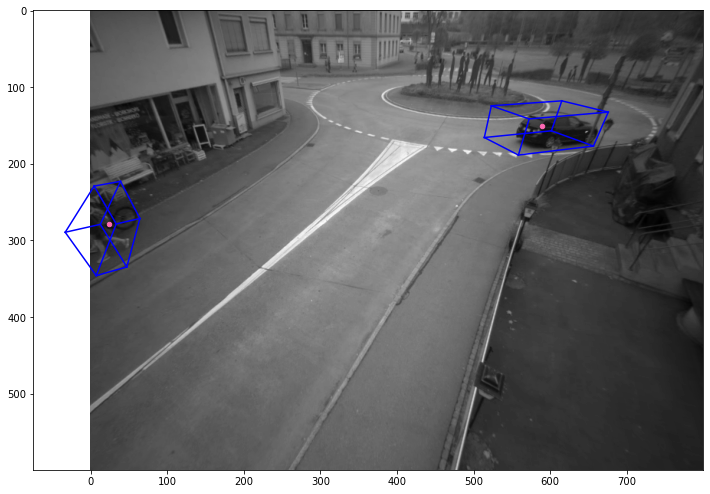

In [32]:
visualize_frame_boxes(hdf5data_130, 0, figsize = (12,12), s = 20)

In [33]:
def belongs_to(point, box, isdf=False):
    #print(point)
    if isdf:
        center = box[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
        point = np.array([i for i in point]) - center
        anti_rotation_matrix = np.array([[np.cos(-box['angle_box'].to_numpy()[0]), -np.sin(-box['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(-box['angle_box'].to_numpy()[0]), np.cos(-box['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
        rot_point = anti_rotation_matrix.dot(point)
        #print("point: ", point)
        #print(rot_point)
        if np.abs(rot_point[0])<box['length_box'].to_numpy()/2 and np.abs(rot_point[1])<box['width_box'].to_numpy()/2 and np.abs(rot_point[2])<box['height_box'].to_numpy()/2:
            return True
        return False
    
    center = np.array([i for i in box[0]])
    point = np.array([i for i in point]) - center
    anti_rotation_matrix = np.array([[np.cos(-box[4]), -np.sin(-box[4]), 0], 
                            [np.sin(-box[4]), np.cos(-box[4]), 0], 
                            [0,0,1]])
    rot_point = anti_rotation_matrix.dot(point)
    
    if np.abs(rot_point[0])<box[1]/2 and np.abs(rot_point[1])<box[2]/2 and np.abs(rot_point[2])<box[3]/2:
        return True
    return False

def compute_approx_IoU(box1, box2, attempts=10): #TODO increment number iterations
    
    #print(box1)
    #print(box2)
    

    pos1 = box1[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    pos2 = box2[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    #print(pos1, pos2)
    length1 = box1['length_box'].to_numpy()[0]
    width1 = box1['width_box'].to_numpy()[0]
    height1 = box1['height_box'].to_numpy()[0]
    length2 = box2['length_box'].to_numpy()[0]
    width2 = box2['width_box'].to_numpy()[0]
    height2 = box2['height_box'].to_numpy()[0]
    diag1 = np.sqrt(length1**2+width1**2+height1**2)
    diag2 = np.sqrt(length2**2+width2**2+height2**2)
    rotation_matrix1 = np.array([[np.cos(box1['angle_box'].to_numpy())[0], -np.sin(box1['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(box1['angle_box'].to_numpy()[0]), np.cos(box1['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
    rotation_matrix2 = np.array([[np.cos(box2['angle_box'].to_numpy()[0]), -np.sin(box2['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(box2['angle_box'].to_numpy()[0]), np.cos(box2['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
    
    
    if np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2+(pos1[2]-pos2[2])**2)>max(diag1, diag2):
        return 0
    intersection = 0
    #print("arr",np.array([length1,width1,height1]))
    for i in range(attempts):
        u = np.random.uniform(-1,1,size=3) * np.array([length1,width1,height1])/2 
        #print(np.array([i for i in pos1]))
        #print("u: ", u)
        u = rotation_matrix1.dot(u)
        if belongs_to(u + np.array([i for i in pos1]), box2, True):
            intersection +=1
        u = np.random.uniform(-1,1,size=3) * np.array([length2,width2,height2])/2 
        u = rotation_matrix2.dot(u)
        if belongs_to(u + np.array([i for i in pos2]), box1, True):
            intersection +=1
    return intersection/2/attempts

# def find_intersecting_boxes_df(detection1, detection2, threshold=0.2, all_matches=False):
#     return_df = pd.DataFrame(columns=['camera1', 'camera2','original_idx1','original_idx2','iou', 'bestmatch1', 'bestmatch2'])
    
#     for idx, det in detection1.iterrows():
#         for idxx, dett in detection2.iterrows():
    
#             iou = compute_approx_IoU(det,dett)
#             if iou > threshold:
#                 return_df = return_df.append({'camera1': det['camera'], 'camera2': dett['camera'],'original_idx1':idx, 'original_idx2':idxx, 'iou': iou, 'bestmatch1': False, 'bestmatch2': False}, ignore_index=True)
    
#     best1idx = return_df.groupby(['camera1', 'original_idx1'])['iou'].idxmin()            
#     best2idx = return_df.groupby(['camera2', 'original_idx2'])['iou'].idxmin() 
#     return_df.loc[best1idx, 'bestmatch1'] = True
#     return_df.loc[best2idx, 'bestmatch2'] = True
#     if all_matches:
#         return return_df
#     return return_df.loc[return_df[['bestmatch1', 'bestmatch2']].any()]

def find_subsequent_boxes(track_list1, track_list2, threshold=0.2, return_iou=False):
    """
    Returns a numpy array of the best matches of boxes in track_list2 for boxes in track_list1, if any 
    If no IoU above a fixed threshold is found, -1 is assigned.
    Optionally it will also return ious
    """
    
    iou_vec = np.zeros(shape=len(track_list1))
    matches = -np.ones(shape=len(track_list1), dtype=np.int8)
    for i in range(len(track_list1)):
        for j in range(len(track_list2)):
#             print(track_list1[i])
#             print(track_list2[j])
#             print(track_list1[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten())
            df1 = track_list1[i].to_df()
            #df2 = track_list2[j].to_df()
            last_frame = df1.frame.max()
            iou = compute_approx_IoU(df1[df1.frame==last_frame],track_list2[j].to_df())
            if iou > iou_vec[i] and iou > threshold: # can be refined to also account for very different volumes
                iou_vec[i] = iou
                matches[i] = j
        #print(matches)        
        #can use this to check if there is any split, uncertainty, etc
        if not return_iou:
            return matches
    return matches, iou_vec